### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for heatmap generation

In [2]:
# sample log file path
FILE_PATH = "sample-log.log"


---


### Parsing Log file into readable pandas DataFrame

In [3]:
def parse_log_line(log_line: str) -> pd.DataFrame:
    """Parse log line into suitable object."""
    # indices of notations
    square_bracket_1 = log_line.find('[')
    square_bracket_2 = log_line.find(']')
    quote_1 = log_line.find('"')
    quote_2 = log_line.find('"', quote_1 + 1)
    quote_3 = log_line.find('"', quote_2 + 1)
    quote_5 = log_line.find('"', quote_3 + 1 + 1 + 1)
    quote_6 = log_line.find('"', quote_5 + 1)
    end = log_line.find('\n')
    # extract ips
    ip = log_line[:square_bracket_1].split(sep=' ')[0]
    # extract regions
    region = log_line[:square_bracket_1].split(sep=' ')[2]
    # extract timestamp
    timestamp = log_line[square_bracket_1 + 1 : square_bracket_2]
    # request = method + url + protocol
    request = log_line[quote_1 + 1 : quote_2].split(sep=' ')
    method, url, protocol = request[0], request[1], request[2]
    status = log_line[quote_2 + 1 : quote_3].split(sep=' ')[1]
    size = log_line[quote_2 + 1 : quote_3].split(sep=' ')[2]
    # extract user agent
    user_agent = log_line[quote_5 + 1 : quote_6]
    # extract connection duration
    duration = log_line[quote_6 + 1 : end]
    return {
        'ip': ip, 'region': region, 'timestamp': timestamp, 
        'method': method, 'url': url, 'protocol': protocol,
        'status': status, 'size': size,
        'user_agent': user_agent, 'duration (ms)': duration
    }

# parse log file into dataframe
records = []
try: 
    with open(FILE_PATH, 'r', encoding="utf-8") as f:
        # use function earlier to parse log line by line
        for line in f:
            records.append(parse_log_line(line))
except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found.")
# empty df if none got parse
if not records:
    records = pd.DataFrame()
# convert from array to dataframe
df = pd.DataFrame(records)
# Adjustment to correct format
## dd/mm/yyyy format timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y:%H:%M:%S')
## numerical format for suitable columns
df['status'] = pd.to_numeric(df['status'])
df['size'] = pd.to_numeric(df['size'])
df.dropna(inplace=True)

df.head()

,ip,region,timestamp,method,url,protocol,status,size,user_agent,duration (ms)
0,100.34.17.233,NO,2025-07-01 06:00:02,GET,/news/grammy-nominations-2024,HTTP/1.1,302,1234,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,269
1,173.80.18.254,NO,2025-07-01 06:00:04,POST,/,HTTP/1.1,200,1234,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,124
2,10.3.0.48,SE,2025-07-01 06:00:06,GET,/podcasts/behind-the-beat,HTTP/1.1,200,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,284
3,172.56.143.33,US,2025-07-01 06:00:08,GET,/terms-of-service,HTTP/1.1,200,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,262
4,208.54.157.184,NO,2025-07-01 06:00:09,POST,/privacy-policy,HTTP/1.1,200,1234,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,118



---


### Traffic Analysis

#### 1. Find Suspicious IP Addresses

In [4]:
# ips information
requests = df.size
unique_ip = df['ip'].nunique()
average_requests = round(requests / unique_ip)

print(f"Total requests: {requests}")
print(f"Total number of unique IP address: {unique_ip}")
print(f"Average requests per IP: {average_requests} (rounded)")

Total requests: 4320960
Total number of unique IP address: 40887
Average requests per IP: 106 (rounded)


In [5]:
# top ips with largest requests that's more than average
top_ips = df['ip'].value_counts().nlargest(20)
suspicious_ips = top_ips[top_ips > average_requests]
suspicious_ips.name = "top ips with largest requests that's more than average"

suspicious_ips

ip
45.133.1.2         5400
45.133.1.1         5400
35.185.0.156       3600
194.168.1.2        1859
194.168.1.6        1855
194.168.1.8        1831
194.168.1.3        1798
194.168.1.1        1789
194.168.1.7        1767
194.168.1.4        1763
194.168.1.5        1738
185.220.101.19     1440
185.220.101.86     1440
185.220.101.78     1440
185.220.100.77     1440
185.220.102.135    1440
Name: top ips with largest requests that's more than average, dtype: int64

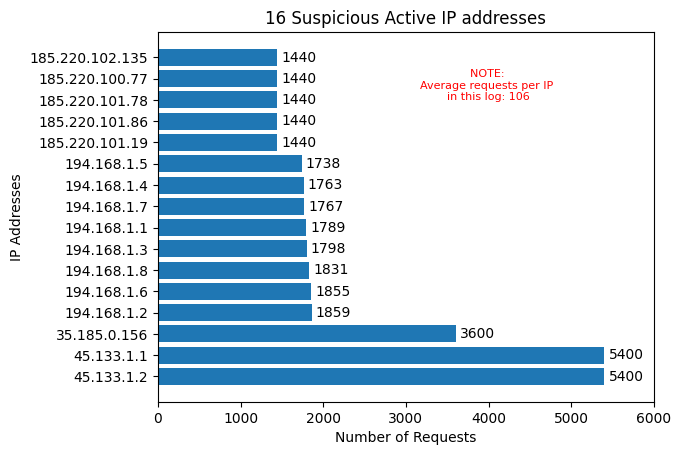

In [6]:
# generate visualisation on suspicious IP addresses
fig, ax = plt.subplots()
bars = ax.barh(suspicious_ips.index, suspicious_ips.values)
ax.bar_label(bars, padding=3)
ax.set_xlabel('Number of Requests')
ax.set_ylabel('IP Addresses')
ax.set_xlim(right=6000) # set the max limit of x-axis
ax.set_title(f'{suspicious_ips.size} Suspicious Active IP addresses')    
ax.text(4000, 13, f'NOTE: \nAverage requests per IP \nin this log: {average_requests}', 
        ha="center", fontsize=8 ,color='red')

plt.show()

#### 2. Observer Suspicious IPs traffic over time

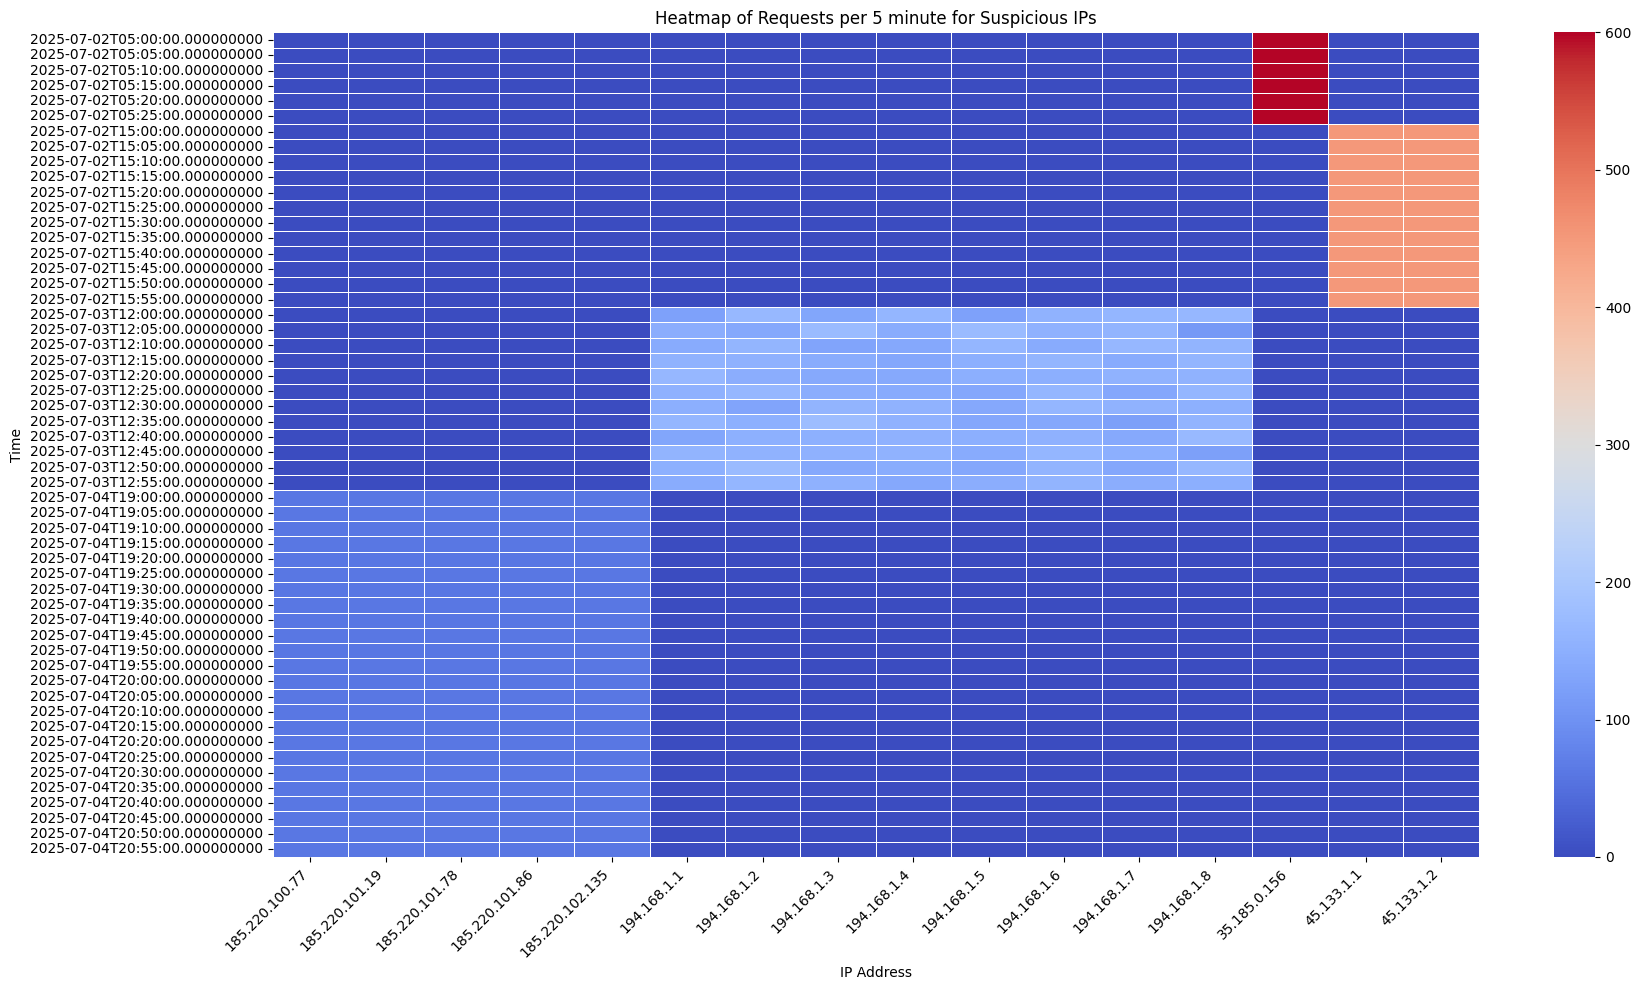

In [7]:
# create pivot table - IPs on x-axis, timestamp on y-axis
heatmap_data = ((df[df['ip'].isin(suspicious_ips.index)]).set_index('timestamp')
                                                         .groupby('ip')
                                                         .resample('5Min')['url'].size()
                                                         .unstack(level='ip')
                                                         .fillna(0))
# plot heatmap
plt.figure(figsize=(18, 10))
# import seaborn as sns
map = sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of Requests per 5 minute for Suspicious IPs")
plt.xlabel("IP Address")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Time')
plt.tight_layout()
plt.show()

#### 3. Suspicious IPs Analysis

##### 3.1. Analysing IPs with pattern 45.133.1.x

In [8]:
# filter the parsed df with only ips_45
df_ips_45 = df[df['ip'].str.contains(r'45.133.1.')]

df_ips_45

,ip,region,timestamp,method,url,protocol,status,size,user_agent,duration (ms)
151435,45.133.1.1,RU,2025-07-02 15:00:00,OPTIONS,/api/v1/users,HTTP/1.1,200,1234,nikto/2.1.6,166
151436,45.133.1.1,RU,2025-07-02 15:00:00,OPTIONS,/api/v2/users/../,HTTP/1.1,404,1234,HTTPie/3.2.0,154
151437,45.133.1.1,RU,2025-07-02 15:00:00,OPTIONS,/api/v3/users/../../,HTTP/1.1,404,1234,Burp Suite Professional,205
151442,45.133.1.2,RU,2025-07-02 15:00:01,GET,/api/v4/users/../../../,HTTP/1.1,404,1234,nikto/2.1.6,292
151443,45.133.1.2,RU,2025-07-02 15:00:01,HEAD,/api/v5/users/admin,HTTP/1.1,404,1234,curl/7.68.0,85
...,...,...,...,...,...,...,...,...,...,...
174796,45.133.1.1,RU,2025-07-02 15:59:58,PUT,/api/backup/0,HTTP/1.1,200,1234,sqlmap/1.6.12,53
174797,45.133.1.1,RU,2025-07-02 15:59:58,GET,/api/database/-1,HTTP/1.1,404,1234,Burp Suite Professional,119
174801,45.133.1.2,RU,2025-07-02 15:59:59,POST,/api/files/999999,HTTP/1.1,404,1234,OWASP ZAP,153
174802,45.133.1.2,RU,2025-07-02 15:59:59,HEAD,/api/upload/null,HTTP/1.1,200,1234,OWASP ZAP,134


In [9]:
# find potential bot pattern on user agent
bot = ['bot', 'spider', 'crawler', 'python-request']
bot_pattern = '|'.join(bot) # '|' means bitstring OR
bot_traffic_ips_45 = df_ips_45[df_ips_45['user_agent'].str.contains(bot_pattern, case=False, na=False)]
if bot_traffic_ips_45.empty:
    print("None of the traffic found to using a bot-like user agent with IPs 45.133.1.x")
# show type of agent/s used
type_bot_traffic_ips_45 = bot_traffic_ips_45['user_agent'].value_counts()
type_bot_traffic_ips_45.name = "bot-like user agent used in ips_45"
print(type_bot_traffic_ips_45)

print()

# show non bot user agent
traffic_ips_45 = df_ips_45[~df_ips_45['user_agent'].str.contains(bot_pattern, case=False, na=False)]
type_traffic_ips_45 = traffic_ips_45['user_agent'].value_counts()
type_traffic_ips_45.name = "other user agents used in ips_45"
print(type_traffic_ips_45)

user_agent
python-requests/2.28.1    1165
Name: bot-like user agent used in ips_45, dtype: int64

user_agent
sqlmap/1.6.12                                      1267
Postman/1.0                                        1246
OWASP ZAP                                          1235
curl/7.68.0                                        1232
nikto/2.1.6                                        1184
HTTPie/3.2.0                                       1182
Burp Suite Professional                            1172
Mozilla/5.0 (compatible; Nmap Scripting Engine)    1117
Name: other user agents used in ips_45, dtype: int64


In [10]:
# get the list of unique url affected by the bot-like user agent
url_bot_ips_45 = bot_traffic_ips_45['url'].value_counts()
url_bot_ips_45.name = "url that got affected by bot-like user agent"
print(f'Number of unique url affected by bot-like user agent: {url_bot_ips_45.size}')
print("-------------------------------------------------------------")
print(url_bot_ips_45)

print()

# get the list of unique url affected by non-bot user agents
url_ips_45 = traffic_ips_45['url'].value_counts()
url_ips_45.name = "url that requested by other user agents"
print(f'Number of unique url that requested by other user agents: {url_ips_45.size}')
print("----------------------------------------------------------------")
print(url_ips_45)

Number of unique url affected by bot-like user agent: 753
-------------------------------------------------------------
url
/api/v5/auth/login/test          5
/api/v1/auth/token/undefined     4
/api/v3/users/settings/1         4
/api/v2/auth/token/-1            4
/api/v4/admin/settings/config    4
                                ..
/api/v5/admin/settings           1
/api/v4/users/profile/-1         1
/api/metrics/debug               1
/api/v5/database/0               1
/api/v5/admin/logs/undefined     1
Name: url that got affected by bot-like user agent, Length: 753, dtype: int64

Number of unique url that requested by other user agents: 1200
----------------------------------------------------------------
url
/api/v2/users/../           9
/api/v3/users/../../        9
/api/v4/users/../../../     9
/api/v2/billing/1           9
/api/v2/config/debug        9
                           ..
/api/v2/auth/token/-1       5
/api/v4/backup/0            5
/api/v3/users/settings/1    5
/api/v1/au

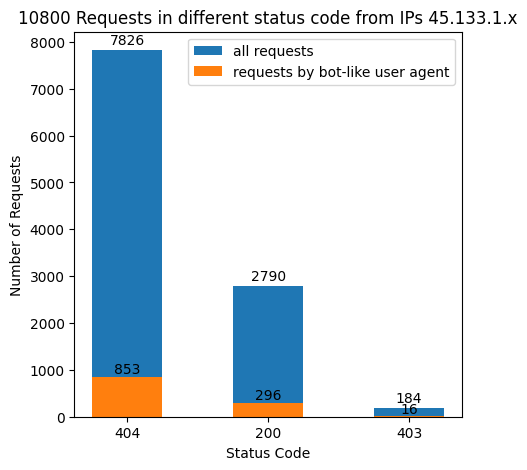

In [11]:
# extract and analyse the status
status_ips_45 = df_ips_45['status'].value_counts()
status_ips_45.index = status_ips_45.index.astype(str)
status_ips_45.name = "Different status in ips_45"
# extract and analyse the status (by bot-like user agent)
bot_status_ips_45 = bot_traffic_ips_45['status'].value_counts()
bot_status_ips_45.index = bot_status_ips_45.index.astype(str)
bot_status_ips_45.name = "Different status in ips_45 from bot-like user agent"

# plot bar graph
fig, ax = plt.subplots(figsize=(5, 5))
bars = ax.bar(status_ips_45.index, status_ips_45.values, width=0.5)
ax.bar_label(bars, label_type='edge', padding=2)
bars_bot = ax.bar(bot_status_ips_45.index, bot_status_ips_45.values, width=0.5)
ax.bar_label(bars_bot)
ax.legend(["all requests", "requests by bot-like user agent"])
ax.set_xlabel('Status Code')
ax.set_ylabel('Number of Requests')
ax.set_title(f"{status_ips_45.values.sum()} Requests in different status code from IPs 45.133.1.x")
plt.show()

In [12]:
# check its attack timestamp
start_time = df_ips_45['timestamp'].min()
end_time = df_ips_45['timestamp'].max()
duration = int((end_time - start_time).total_seconds())
days = ((duration//3600) % 24) if (duration//3600 >= 24) else 0
hours = ((duration//3600) - (days*24)) if (days >= 1) else (duration//3600)
minutes = (duration % 3600) // 60
seconds = duration % 60

print(f'Attack timeframe from IPs 45.133.1.x :\n', 
      f'-> from {start_time} to {end_time} \n',
      f'-> duration: {days} days, {hours} hours, {minutes} minutes and {seconds} seconds')

Attack timeframe from IPs 45.133.1.x :
 -> from 2025-07-02 15:00:00 to 2025-07-02 15:59:59 
 -> duration: 0 days, 0 hours, 59 minutes and 59 seconds


In [13]:
# find attack region/s
region_ips_45 = df_ips_45['region'].unique()
print(f'{region_ips_45.size} region/s got affected: \n{region_ips_45}')

1 region/s got affected: 
['RU']


<table style="font-size:12px;border:solid;">
    <tr>
        <td><strong>Conclusion on IPs 45.133.1.x: <ins>API Attack</ins></strong></td>
    </tr>
    <tr>
        <td>
        There are 10800 requests targeted on 1200+ various unique API endpoints using various user agents.<br/> 
        Among these 10800 requests, there are 1165 requests targeting on 753 various unique API endpoints using systematic enumeration with <code>python-requests/2.28.1</code>. <br/><br/>
        Besides that, there are 7826 requests with <code>404</code> HTTP error status, and 184 requests with <code>403</code> authentication error status, a total of 8010 error status out of 10800 requests. <br/>
        User agent <code>python-requests/2.28.1</code> causes 853 <code>404</code> errors and 16 <code>403</code> errors.<br/><br/>
        The total attack duration is 1 hour, in between 15:00 and 16:00 on 02/07/2025.<br/><br/>
        A total of 1 region got affected by this API attack - RU (Russia).
        </td>
    </tr>
    <tr>
        <td>IPs: <code>45.133.1.1</code>, <code>45.133.1.2</code></td>
    </tr>
</table>

##### 3.2. Analysing IP 35.185.0.156

In [14]:
# filter the parsed df with only ip 35.185.0.156
df_ip_35 = df[df['ip'].str.contains('35.185.0.156')]

df_ip_35

,ip,region,timestamp,method,url,protocol,status,size,user_agent,duration (ms)
99202,35.185.0.156,US,2025-07-02 05:00:00,GET,/search?year=2024,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),353
99203,35.185.0.156,US,2025-07-02 05:00:00,GET,/search,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),477
99204,35.185.0.156,US,2025-07-02 05:00:01,GET,/search,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),264
99205,35.185.0.156,US,2025-07-02 05:00:01,GET,/search?genre=ambient+soundscapes&s=The+1975&y...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),446
99206,35.185.0.156,US,2025-07-02 05:00:02,GET,/search?s=Fontaines+D.C.&s=Arctic+Monkeys&dura...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),477
...,...,...,...,...,...,...,...,...,...,...
102797,35.185.0.156,US,2025-07-02 05:29:57,GET,/search?genre=alternative+rock&sort=alphabetic...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),342
102798,35.185.0.156,US,2025-07-02 05:29:58,GET,/search?genre=blues&sort=popularity&year=2023&...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),314
102799,35.185.0.156,US,2025-07-02 05:29:58,GET,/search?sort=date&s=The+1975&sort=date&sort=po...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),211
102800,35.185.0.156,US,2025-07-02 05:29:59,GET,/search?duration=medium&year=2020&year=2024&du...,HTTP/1.1,200,1234,Wget/1.20.3 (linux-gnu),110


In [15]:
# find potential bot pattern on user agent
bot = ['bot', 'spider', 'crawler', 'python-request']
bot_pattern = '|'.join(bot) # '|' means bitstring OR
bot_traffic_ip_35 = df_ip_35[df_ip_35['user_agent'].str.contains(bot_pattern, case=False, na=False)]
if bot_traffic_ip_35.empty:
    print("None of the traffic found to using a bot-like user agent with IP 35.185.0.156")

print()

# show all different user agent
user_agent_ip_35 = df_ip_35['user_agent'].value_counts()
user_agent_ip_35.name = "user agent used by ip 35.185.0.156"
print(user_agent_ip_35)

None of the traffic found to using a bot-like user agent with IP 35.185.0.156

user_agent
Wget/1.20.3 (linux-gnu)    3600
Name: user agent used by ip 35.185.0.156, dtype: int64


In [16]:
# get the list of unique url requested from ip 35.185.0.156
url_ip_35 = df_ip_35['url'].value_counts()
url_ip_35.name = "unique url that are requested from ip 35.185.0.156"

print(f'Number of unique url affected: {url_ip_35.size}')
url_ip_35

Number of unique url affected: 2280


url
/search                                                                              585
/search?sort=popularity                                                               49
/search?duration=long                                                                 47
/search?sort=alphabetical                                                             45
/search?duration=medium                                                               45
                                                                                    ... 
/search?s=Tame+Impala&s=The+1975&sort=date&sort=date&duration=short                    1
/search?duration=medium&sort=date&s=The+1975&genre=indie+rock                          1
/search?genre=classical&genre=punk+rock&year=2023&duration=long                        1
/search?year=2023&s=Wet+Leg                                                            1
/search?duration=medium&s=Billie+Eilish&duration=long&sort=alphabetical&year=2023      1
Name: unique url 

In [17]:
# extract and analyse the status
status_ip_35 = df_ip_35['status'].value_counts()
status_ip_35.name = "Different status in ip 35.185.0.156"
status_ip_35

print(f'\nNo error status. All {status_ip_35[200]} requests ended with OK (200) status.')


No error status. All 3600 requests ended with OK (200) status.


In [18]:
# check its attack timestamp
start_time = df_ip_35['timestamp'].min()
end_time = df_ip_35['timestamp'].max()
duration = int((end_time - start_time).total_seconds())
days = ((duration//3600) % 24) if (duration//3600 >= 24) else 0
hours = ((duration//3600) - (days*24)) if (days >= 1) else (duration//3600)
minutes = (duration % 3600) // 60
seconds = duration % 60

print(f'Attack timeframe from IP 35.185.0.156 :\n', 
      f'-> from {start_time} to {end_time} \n',
      f'-> duration: {days} days, {hours} hours, {minutes} minutes and {seconds} seconds')

Attack timeframe from IP 35.185.0.156 :
 -> from 2025-07-02 05:00:00 to 2025-07-02 05:29:59 
 -> duration: 0 days, 0 hours, 29 minutes and 59 seconds


In [19]:
# find attack region/s
region_ip_35 = df_ip_35['region'].unique()
print(f'{region_ip_35.size} region/s got affected: \n{region_ip_35}')

1 region/s got affected: 
['US']


<table style="font-size:12px;border:solid;">
    <tr>
        <td><strong>Conclusion on IP 35.185.0.156: <ins>Web Scrapper</ins></strong></td>
    </tr>
    <tr>
        <td>This IP called 3,600 requests with user agent <em>Wget/1.20.3 (linux-gnu)</em>, accessing 2280 various unique search endpoints. <br>
        All requests are accessed without error status (<code>OK</code> 200 status for all requests).<br><br>
        The attack duration is 30 minutes, in between 05:00 and 06:00 on 02/07/2025.<br><br>
        A total of 1 region got affected by this web scrapping - US (United States).
        </td>
    </tr>
</table>

##### 3.3. Analysing IPs with pattern 194.168.1.x

In [20]:
# filter the parsed df with only ips_194
df_ips_194 = df[df['ip'].str.contains(r'194.168.1.')]

df_ips_194

,ip,region,timestamp,method,url,protocol,status,size,user_agent,duration (ms)
237540,194.168.1.6,UK,2025-07-03 12:00:00,GET,/interviews/studio-sessions-with-legends,HTTP/1.1,200,1234,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,331
237541,194.168.1.3,UK,2025-07-03 12:00:00,GET,/contact,HTTP/1.1,200,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,128
237542,194.168.1.6,UK,2025-07-03 12:00:00,GET,/search,HTTP/1.1,200,1234,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,409
237543,194.168.1.7,UK,2025-07-03 12:00:00,GET,/episodes/ep-42-synthesizer-history,HTTP/1.1,200,1234,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,71
237547,194.168.1.8,UK,2025-07-03 12:00:01,GET,/search?s=Phoebe+Bridgers,HTTP/1.1,200,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,486
...,...,...,...,...,...,...,...,...,...,...
264595,194.168.1.2,UK,2025-07-03 12:59:58,GET,/search?year=2022,HTTP/1.1,503,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,199
264600,194.168.1.6,UK,2025-07-03 12:59:59,GET,/news/grammy-nominations-2024,HTTP/1.1,429,1234,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,344
264601,194.168.1.4,UK,2025-07-03 12:59:59,GET,/subscribe-premium,HTTP/1.1,504,1234,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,116
264602,194.168.1.2,UK,2025-07-03 12:59:59,GET,/search?duration=long&sort=alphabetical&sort=p...,HTTP/1.1,500,1234,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,278


In [21]:
# find potential bot pattern on user agent
bot = ['bot', 'spider', 'crawler', 'python-request']
bot_pattern = '|'.join(bot) # '|' means bitstring OR
bot_traffic_ips_194 = df_ips_194[df_ips_194['user_agent'].str.contains(bot_pattern, case=False, na=False)]
if bot_traffic_ips_194.empty:
    print("None of the traffic found to using a bot-like user agent with IPs 194.168.1.x")

print()

# show all different user agent
user_agent_ips_194 = df_ips_194['user_agent'].value_counts()
user_agent_ips_194.name = "user agent used by ips_194"
print(user_agent_ips_194)

None of the traffic found to using a bot-like user agent with IPs 194.168.1.x

user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36                              5421
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Version/17.2.1 Safari/537.36                          3538
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36 Edg/120.0.0.0                1871
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36                        1807
Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1    1763
Name: user agent used by ips_194, dtype: int64


In [22]:
# get the list of unique url requested from ips_194
url_ips_194 = df_ips_194['url'].value_counts()
url_ips_194.name = "unique url that are requested from ips_194"

print(f'Number of unique url affected: {url_ips_194.size}')
url_ips_194

Number of unique url affected: 3864


url
/search                                                                             1158
/privacy-policy                                                                      563
/about                                                                               542
/contact                                                                             540
/articles/the-evolution-of-jazz                                                      540
                                                                                    ... 
/search?genre=reggae&genre=blues&year=2025                                             1
/search?genre=jazz+fusion&year=2025                                                    1
/search?s=Foals&s=CMAT&duration=short&genre=hip+hop                                    1
/search?genre=country+music&s=Wolf+Alice&genre=indie+rock&year=2021&s=Wolf+Alice       1
/search?year=2022&year=2020                                                            1
Name: unique url 

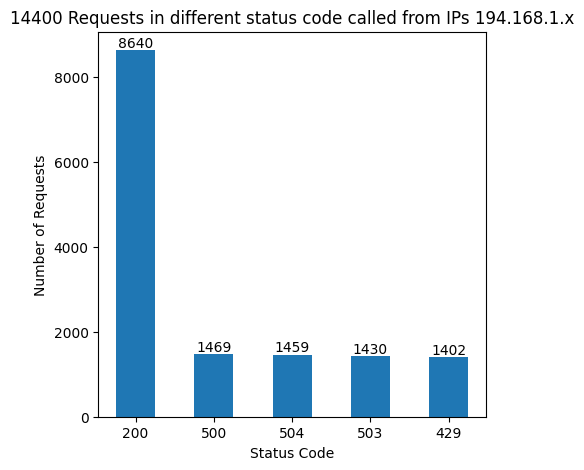

In [23]:
# extract and analyse the status
status_ips_194 = df_ips_194['status'].value_counts()
status_ips_194.index = status_ips_194.index.astype(str)
status_ips_194.name = "Different status in ips_194"

fig, ax = plt.subplots(figsize=(5, 5))
bars = ax.bar(status_ips_194.index, status_ips_194.values, width=0.5)
ax.bar_label(bars)
ax.set_xlabel('Status Code')
ax.set_ylabel('Number of Requests')
ax.set_title(f"{status_ips_194.values.sum()} Requests in different status code called from IPs 194.168.1.x")
plt.show()

In [24]:
# check its attack timestamp
start_time = df_ips_194['timestamp'].min()
end_time = df_ips_194['timestamp'].max()
duration = int((end_time - start_time).total_seconds())
days = ((duration//3600) % 24) if (duration//3600 >= 24) else 0
hours = ((duration//3600) - (days*24)) if (days >= 1) else (duration//3600)
minutes = (duration % 3600) // 60
seconds = duration % 60

print(f'Attack timeframe from IPs 194.168.1.x :\n', 
      f'-> from {start_time} to {end_time} \n',
      f'-> duration: {days} days, {hours} hours, {minutes} minutes and {seconds} seconds')

Attack timeframe from IPs 194.168.1.x :
 -> from 2025-07-03 12:00:00 to 2025-07-03 12:59:59 
 -> duration: 0 days, 0 hours, 59 minutes and 59 seconds


In [25]:
# find attack region/s
region_ips_194 = df_ips_194['region'].unique()
print(f'{region_ips_194.size} region/s got affected: \n{region_ips_194}')

1 region/s got affected: 
['UK']


<table style="font-size:12px;border:solid;">
    <tr>
        <td><strong>Conclusion on IPs 194.168.1.x: Overloaded Requests within specific timeframe</strong></td>
    </tr>
    <tr>
        <td>Among these 14400 requests, there are 1469 <code>500</code> internal server error, 1459 <code>504</code> gateway timeout error, 1430 <code>503</code> service unavailable error <br> and 1429 <code>429</code> too many requests error. A total of 5787 requests with errors. <br><br>
        These IPs might had exceeded requests limit within a specific timeframe, leading to server overwhelm, causes internal server errors, then causes gateway timeout. <br><br>
        The attack duration is 1 hour, in between 12:00 and 13:00 on 03/07/2025.<br><br>
        A total of 1 region that got affected by these IPs - <code>UK</code> (United Kingdom).
        </td>
    </tr>
    <tr>
        <td>IPs: <code>194.168.1.2</code>, <code>194.168.1.6</code>, <code>194.168.1.8</code>, <code>194.168.1.3</code>, <code>194.168.1.1</code>, <code>194.168.1.7</code>, <code>194.168.1.4</code>, <code>194.168.1.5</code></td>
    </tr>
</table>

##### 3.4. Analysing IPs with pattern 185.220.x.x

In [26]:
# filter the parsed df with only ips_194
df_ips_185 = df[df['ip'].str.contains(r'185.220.')]

df_ips_185

,ip,region,timestamp,method,url,protocol,status,size,user_agent,duration (ms)
417667,185.220.101.86,IR,2025-07-04 19:00:00,POST,/api/auth/login?username=admin&password=password,HTTP/1.1,200,1234,Apache-HttpClient/4.5.13,247
417668,185.220.102.135,KP,2025-07-04 19:00:01,POST,/api/v1/auth/login?username=admin&password=123456,HTTP/1.1,200,1234,curl/7.68.0,462
417670,185.220.101.19,CN,2025-07-04 19:00:02,POST,/login?username=admin&password=password123,HTTP/1.1,401,1234,Apache-HttpClient/4.5.13,127
417672,185.220.101.78,IR,2025-07-04 19:00:03,POST,/api/login?username=admin&password=admin,HTTP/1.1,401,1234,Apache-HttpClient/4.5.13,207
417674,185.220.100.77,IR,2025-07-04 19:00:04,POST,/admin/login?username=admin&password=qwerty,HTTP/1.1,401,1234,okhttp/4.9.3,254
...,...,...,...,...,...,...,...,...,...,...
428531,185.220.101.86,CN,2025-07-04 20:59:55,POST,/api/login?username=jennifer&password=password...,HTTP/1.1,429,1234,Apache-HttpClient/4.5.13,115
428533,185.220.102.135,RU,2025-07-04 20:59:56,POST,/admin/login?username=jennifer&password=admin%...,HTTP/1.1,401,1234,PostmanRuntime/7.32.3,241
428535,185.220.101.19,IR,2025-07-04 20:59:57,POST,/api/admin/login?username=jennifer&password=12...,HTTP/1.1,401,1234,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,118
428537,185.220.101.78,CN,2025-07-04 20:59:58,POST,/auth/signin?username=jennifer&password=87654321,HTTP/1.1,401,1234,HTTPie/3.2.0,268


In [27]:
# find potential bot pattern on user agent
bot = ['bot', 'spider', 'crawler', 'python-request']
bot_pattern = '|'.join(bot) # '|' means bitstring OR
bot_traffic_ips_185 = df_ips_185[df_ips_185['user_agent'].str.contains(bot_pattern, case=False, na=False)]
if bot_traffic_ips_185.empty:
    print("None of the traffic found to using a bot-like user agent with IPs 185.220.x.x")
# show type of agent/s used
type_bot_traffic_ips_185 = bot_traffic_ips_185['user_agent'].value_counts()
type_bot_traffic_ips_185.name = "bot-like user agent used in ips_185"
print(type_bot_traffic_ips_185)

print() 

# show non bot user agent
traffic_ips_185 = df_ips_185[~df_ips_185['user_agent'].str.contains(bot_pattern, case=False, na=False)]
type_traffic_ips_185 = traffic_ips_185['user_agent'].value_counts()
type_traffic_ips_185.name = "other user agents used in ips_185"
print(type_traffic_ips_185)

user_agent
python-requests/2.28.1    904
Name: bot-like user agent used in ips_185, dtype: int64

user_agent
curl/7.68.0                                                     941
Apache-HttpClient/4.5.13                                        932
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36    911
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36              896
HTTPie/3.2.0                                                    893
PostmanRuntime/7.32.3                                           882
okhttp/4.9.3                                                    841
Name: other user agents used in ips_185, dtype: int64


In [28]:
# get the list of unique url affected by the bot-like user agent
url_bot_ips_185 = bot_traffic_ips_185['url'].value_counts()
url_bot_ips_185.name = "url that got affected by bot-like user agent"
print(f'Number of unique url affected by bot-like user agent: {url_bot_ips_185.size}')
print("-------------------------------------------------------------")
print(url_bot_ips_185)

print()

# get the list of unique url affected by non-bot user agents
url_ips_185 = traffic_ips_185['url'].value_counts()
url_ips_185.name = "url that requested by other user agents"
print(f'Number of unique url that requested by other user agents: {url_ips_185.size}')
print("----------------------------------------------------------------")
print(url_ips_185)

Number of unique url affected by bot-like user agent: 726
-------------------------------------------------------------
url
/api/v1/auth/login?username=james&password=123456           4
/auth/signin?username=jane.smith&password=Password123%21    3
/api/admin/login?username=chris&password=login              3
/api/v1/auth/login?username=david&password=password1        3
/api/admin/login?username=jane.smith&password=login         3
                                                           ..
/api/admin/login?username=emma&password=12345678            1
/api/login?username=user&password=password%40123            1
/api/v1/auth/login?username=user&password=123456789         1
/api/auth/signin?username=user&password=default             1
/api/v1/auth/login?username=user&password=password1         1
Name: url that got affected by bot-like user agent, Length: 726, dtype: int64

Number of unique url that requested by other user agents: 1520
----------------------------------------------------

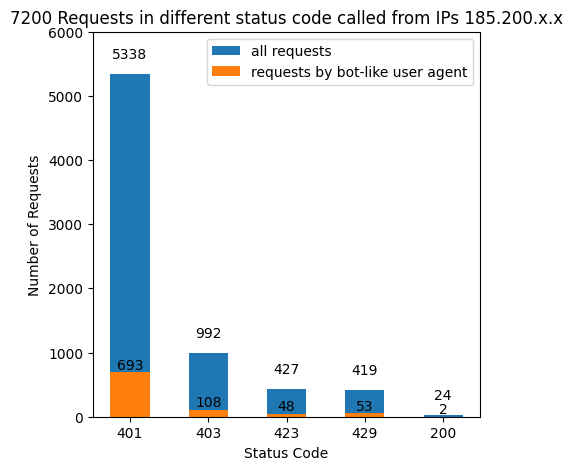

In [29]:
# extract and analyse the status
status_ips_185 = df_ips_185['status'].value_counts()
status_ips_185.index = status_ips_185.index.astype(str)
status_ips_185.name = "Different status in ips_185"
# extract and analyse the status (by bot-like user agent)
bot_status_ips_185 = bot_traffic_ips_185['status'].value_counts()
bot_status_ips_185.index = bot_status_ips_185.index.astype(str)
bot_status_ips_185.name = "Different status in ips_185 by bot-like user agent"

# plot bar graph
fig, ax = plt.subplots(figsize=(5, 5))
bars = ax.bar(status_ips_185.index, status_ips_185.values, width=0.5)
ax.bar_label(bars, padding=9)
bars_bot = ax.bar(bot_status_ips_185.index, bot_status_ips_185.values, width=0.5)
ax.bar_label(bars_bot)
ax.legend(["all requests", "requests by bot-like user agent"])
ax.set_xlabel('Status Code')
ax.set_ylabel('Number of Requests')
ax.set_ylim(0, 6000)
ax.set_title(f"{status_ips_185.values.sum()} Requests in different status code called from IPs 185.200.x.x")
plt.show()

In [30]:
# check its attack timestamp
start_time = df_ips_185['timestamp'].min()
end_time = df_ips_185['timestamp'].max()
duration = int((end_time - start_time).total_seconds())
days = ((duration//3600) % 24) if (duration//3600 >= 24) else 0
hours = ((duration//3600) - (days*24)) if (days >= 1) else (duration//3600)
minutes = (duration % 3600) // 60
seconds = duration % 60

print(f'Attack timeframe from IPs 185.200.x.x :\n', 
      f'-> from {start_time} to {end_time} \n',
      f'-> duration: {days} days, {hours} hours, {minutes} minutes and {seconds} seconds')

Attack timeframe from IPs 185.200.x.x :
 -> from 2025-07-04 19:00:00 to 2025-07-04 20:59:59 
 -> duration: 0 days, 1 hours, 59 minutes and 59 seconds


In [31]:
# find attack region/s
region_ips_185 = df_ips_185['region'].unique()
print(f'{region_ips_185.size} region/s got affected: \n{region_ips_185}')

4 region/s got affected: 
['IR' 'KP' 'CN' 'RU']


<table style="font-size:12px;border:solid;">
    <tr>
        <td><strong>Conclusion on IPs 185.220.x.x: Credential Stuffing Botnet</strong></td>
    </tr>
    <tr>
        <td>
        Among 7200 requests from these IPs, there are 904 requests targeting on 726 login endpoints using bot tool like <code>python-requests/2.28.1</code>. <br/>
        Even the other requests does not called from bot-like user agent, the rest of the 6296 requests still targeting on 1520+ login and sign in API endpoints using other various tools. <br/><br/>
        Besides that, there are 5338 <code>401</code> unauthorised error status, 992 <code>403</code>insufficient permission error, 427 <code>423</code> resource accessbility error status and 419 <code>429</code> "Too Many Requests" status, a total of 7176 error status out of 7200 requests. <br/>
        User agent <code>python-requests/2.28.1</code> causes 693 <code>401</code> errors, 108 <code>403</code> errors, 49 <code>423</code> and 53 <code>429</code> errors.<br/><br/>
        The attack duration is 1 hour, in between 19:00 and 20:00 on 04/07/2025.<br/><br/>
        A total of 4 regions got affected by these IPs - IR (Iran), KP (North Korea), CN (China) and RU (Russia).
        </td>
    </tr>
    <tr>
        <td>IPs: <code>185.220.101.19</code>, <code>185.220.101.86</code>, <code>185.220.101.78</code>, <code>185.220.100.77</code>, <code>185.220.102.135</code></td>
    </tr>
</table>